In [763]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense,RepeatVector, TimeDistributed
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from xgboost import XGBRegressor
print(XGBRegressor)

<class 'xgboost.sklearn.XGBRegressor'>


## Raw Data Processing

In [764]:
ticker = 'KO'
n_days = 1 #Predict 1 day forward
sequence_length = 60 #Will use past 60 days'prices to predict the next day
test_size = 0.2 #20% of the data will be used for testing

In [765]:
start_date = '2015-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

df = yf.download(ticker, start=start_date, end=end_date)
df.columns = df.columns.droplevel(1)
df.dropna(inplace=True)
df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,30.437500,30.625298,30.191920,30.524175,9921100
2015-01-05,30.437500,31.037006,30.394164,30.834762,26292600
2015-01-06,30.668648,31.015349,30.509745,30.632534,16897500
2015-01-07,31.051462,31.138137,30.755321,30.914224,13412300
2015-01-08,31.427042,31.470381,31.130901,31.188686,21743600
...,...,...,...,...,...
2025-05-16,72.000000,72.260002,71.430000,71.860001,18441200
2025-05-19,71.930000,72.169998,71.639999,72.029999,13282800
2025-05-20,71.690002,72.129997,71.430000,71.800003,12137800


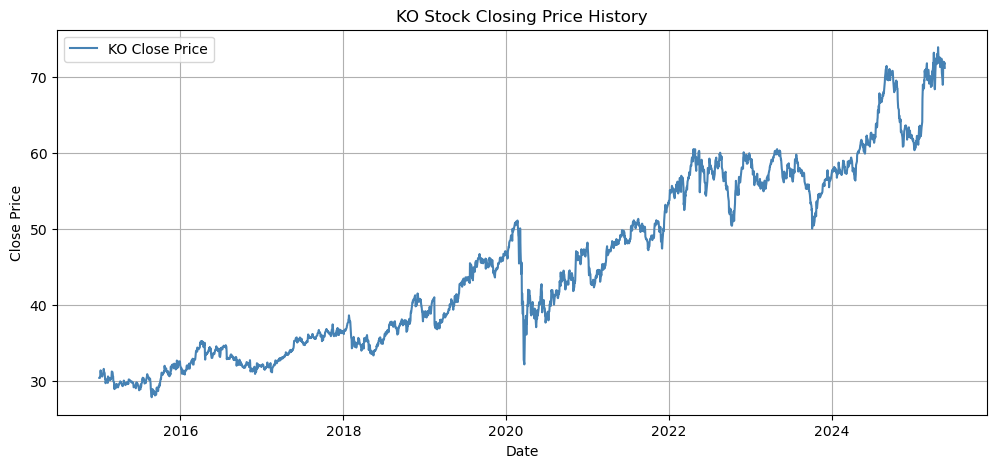

In [766]:
# Visualize the raw data (closing price)
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label=f'{ticker} Close Price', color='steelblue')
plt.title(f'{ticker} Stock Closing Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.show()


## Feature Engineering

In [767]:
def create_features(df, lags=[1, 3, 5, 10, 20], sma_windows=[5, 10, 20, 60], vol_window=20):
    """
    Create feature factors based on OHLCV data.

    Args:
        df (pd.DataFrame): DataFrame containing OHLCV data, indexed by datetime
        lags (list): List of lags for calculating log returns
        sma_windows (list): List of window sizes for calculating simple moving averages (SMA)
        vol_window (int): Window size for calculating volatility

    Returns:
        pd.DataFrame: DataFrame containing generated features (rows with NaNs removed)
    """
    print("Starting feature engineering...")
    df_feat = df.copy()
    
    # Calculate log return (clip to avoid division errors with 0 or negative prices)
    df_feat['log_return'] = np.log(df_feat['Close'].clip(lower=1e-9) / df_feat['Close'].shift(1).clip(lower=1e-9))
    
    # Lagged log return features
    for lag in lags:
        df_feat[f'log_return_lag{lag}'] = df_feat['log_return'].shift(lag)
        
    # Simple Moving Average (SMA) features
    for window in sma_windows:
        df_feat[f'sma_{window}'] = df_feat['Close'].rolling(window=window, min_periods=1).mean()
        # Ratio of price to its SMA (avoid division by zero)
        df_feat[f'price_sma_{window}_ratio'] = df_feat['Close'] / df_feat[f'sma_{window}'].replace(0, 1e-9)
        
    # Ratio between short-term and long-term SMAs
    if len(sma_windows) >= 2:
        sma_short = f'sma_{sma_windows[0]}'
        sma_long = f'sma_{sma_windows[-1]}'
        df_feat[f'sma_ratio'] = df_feat[sma_short] / df_feat[sma_long].replace(0, 1e-9)

    # Volatility feature (std dev of log return over rolling window)
    df_feat[f'volatility_{vol_window}'] = df_feat['log_return'].rolling(window=vol_window, min_periods=1).std()
    
    # Volume-based feature: ratio to rolling mean volume (avoid divide-by-zero)
    vol_mean = df_feat['Volume'].rolling(window=vol_window, min_periods=1).mean()
    df_feat['volume_change_ratio'] = df_feat['Volume'] / vol_mean.replace(0, 1)

    # Drop rows with NaN values (usually caused by lags or rolling windows)
    df_feat = df_feat.dropna() 
    print(f"Feature engineering complete. Generated {len(df_feat.columns) - len(df.columns)} new features. Remaining rows: {len(df_feat)}")
    return df_feat


In [768]:
df = create_features(df, lags=[1, 3, 5, 10, 20], sma_windows=[5, 10, 20, 60], vol_window=20)
df.head()

Starting feature engineering...
Feature engineering complete. Generated 17 new features. Remaining rows: 2592


Price,Close,High,Low,Open,Volume,log_return,log_return_lag1,log_return_lag3,log_return_lag5,log_return_lag10,...,price_sma_5_ratio,sma_10,price_sma_10_ratio,sma_20,price_sma_20_ratio,sma_60,price_sma_60_ratio,sma_ratio,volatility_20,volume_change_ratio
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-03,30.069139,30.228042,29.881341,30.155814,13193100,0.000962,0.010150,0.004285,-0.014288,0.014704,...,0.998753,30.643356,0.981261,30.774816,0.977070,30.744151,0.978044,0.979266,0.010351,0.924958
2015-02-04,30.105253,30.401394,30.061915,30.170260,16400000,0.001200,0.000962,-0.022338,-0.011150,0.004623,...,1.001105,30.522012,0.986346,30.746646,0.979139,30.716373,0.980104,0.979023,0.010183,1.151800
2015-02-05,30.184692,30.206360,29.982448,30.191914,11078500,0.002635,0.001200,0.010150,0.004285,0.009640,...,1.005244,30.378275,0.993628,30.703308,0.983109,30.694219,0.983400,0.978270,0.009734,0.784491
2015-02-06,29.939125,30.163035,29.845226,30.069138,12366400,-0.008169,0.002635,0.000962,-0.022338,-0.010793,...,0.995724,30.243929,0.989922,30.628912,0.977479,30.664016,0.976360,0.980553,0.009305,0.905762
2015-02-09,29.780214,29.939120,29.642979,29.888560,13371100,-0.005322,-0.008169,0.001200,0.010150,-0.007183,...,0.992155,30.116082,0.988848,30.563906,0.974359,30.630023,0.972256,0.979943,0.009109,0.977069


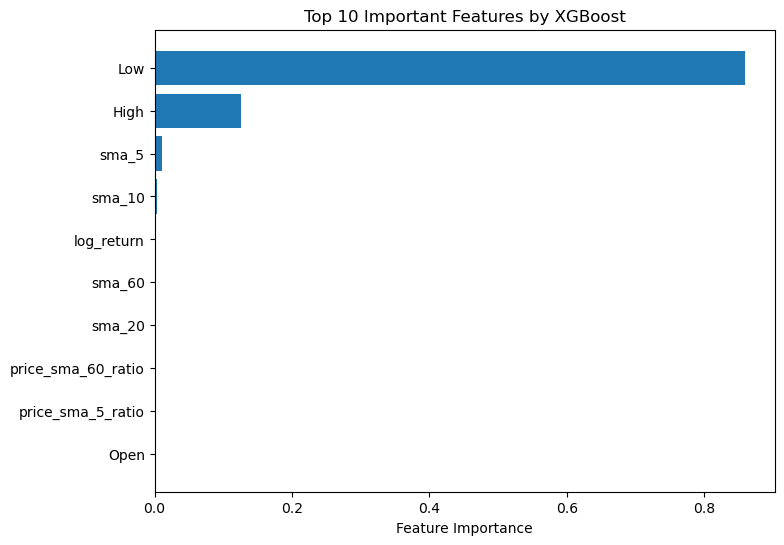

Selected features: ['Low', 'High', 'sma_5', 'sma_10', 'log_return', 'sma_60', 'sma_20', 'price_sma_60_ratio', 'price_sma_5_ratio', 'Open']


In [769]:
def feature_selection_with_xgb(df_feat, target_col='close', top_k=10):
    # define target and features
    X = df_feat.drop(columns=[target_col])
    y = df_feat[target_col]
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, shuffle=False)
    
    # Use XGBoost for feature importance
    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)],verbose=False)
    
    # Get feature importance
    importance = model.feature_importances_
    features = X.columns
    
    # Create a DataFrame for feature importance
    imp_df = pd.DataFrame({'feature': features, 'importance': importance})
    imp_df = imp_df.sort_values(by='importance', ascending=False).head(top_k)
    
    plt.figure(figsize=(8, 6))
    plt.barh(imp_df['feature'], imp_df['importance'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_k} Important Features by XGBoost')
    plt.gca().invert_yaxis()
    plt.show()
    
    return imp_df['feature'].tolist()


top_features = feature_selection_with_xgb(df, target_col='Close', top_k=10)
print("Selected features:", top_features)


In [770]:
df = df[['Close'] + top_features]
df = df.dropna()
df.head()

Price,Close,Low,High,sma_5,sma_10,log_return,sma_60,sma_20,price_sma_60_ratio,price_sma_5_ratio,Open
Date,,,,,,,,,,,
2015-02-03,30.069139,29.881341,30.228042,30.106691,30.643356,0.000962,30.744151,30.774816,0.978044,0.998753,30.155814
2015-02-04,30.105253,30.061915,30.401394,30.072023,30.522012,0.001200,30.716373,30.746646,0.980104,1.001105,30.170260
2015-02-05,30.184692,29.982448,30.206360,30.027240,30.378275,0.002635,30.694219,30.703308,0.983400,1.005244,30.191914
2015-02-06,29.939125,29.845226,30.163035,30.067690,30.243929,-0.008169,30.664016,30.628912,0.976360,0.995724,30.069138
2015-02-09,29.780214,29.642979,29.939120,30.015685,30.116082,-0.005322,30.630023,30.563906,0.972256,0.992155,29.888560


## Preprocessing Dataset

In [771]:
# Choosing between Standardization or normalization
# sc=StandardScaler()
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(data_scaled, columns=df.columns, index=df.index)


In [772]:
# Building the sample for the LSTM
X, y, dates = [], [], []
for i in range(len(scaled_df) - sequence_length - n_days):
    X.append(scaled_df.iloc[i:i+sequence_length].values)
    y.append(scaled_df.iloc[i+sequence_length:i+sequence_length+n_days]['Close'].values)
    dates.append(scaled_df.index[i+sequence_length:i+sequence_length+n_days])

X = np.array(X)
y = np.array(y).reshape(-1, n_days)
dates = np.array(dates)


print('X shape:', X.shape)
print('y shape:', y.shape)
print('y_dates shape:', dates.shape)

X shape: (2531, 60, 11)
y shape: (2531, 1)
y_dates shape: (2531, 1)


In [773]:
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X, y, dates, test_size=test_size, shuffle=False)

## Model Building

In [774]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(units=64, activation='tanh', input_shape=(sequence_length, X.shape[2]), return_sequences=True))
model.add(LSTM(units=32, activation='tanh', return_sequences=False))
model.add(RepeatVector(n_days))
model.add(LSTM(32, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

d:\Software\anaconda\envs\derivativeGP\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [775]:
early_stop = EarlyStopping(
    monitor='val_loss',      
    patience= 25, 
    min_delta=0.0001, 
    verbose=1,             
    restore_best_weights=True 
)

## Model Training

In [776]:
model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0202 - val_loss: 0.0168
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 7.7818e-04 - val_loss: 0.0093
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 6.9883e-04 - val_loss: 0.0073
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 5.5370e-04 - val_loss: 0.0035
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 5.7974e-04 - val_loss: 0.0025
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 3.5934e-04 - val_loss: 0.0026
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.3209e-04 - val_loss: 0.0020
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.1383e-04 - val_loss: 7.7903e-04
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 3.1050e-04 - val_loss: 0.0023
Epoch 10/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 2.1727e-04 - val_loss: 0.0022
Epoch 11/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 2.4355e-04 - val_loss: 9.4477e-04
Epoc

## Model Testing

In [777]:
y_pred = model.predict(X_test)
y_pred = y_pred.squeeze()
print('y_pred shape:', y_pred.shape)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
y_pred shape: (507,)


In [778]:
close_idx = df.columns.get_loc('Close')

y_test_full, y_pred_full = [], []
for i in range(len(y_test)):
    temp = np.zeros((n_days, data_scaled.shape[1]))
    temp[:, close_idx] = y_test[i]
    y_test_full.append(scaler.inverse_transform(temp)[:, close_idx])

    temp[:, close_idx] = y_pred[i]
    y_pred_full.append(scaler.inverse_transform(temp)[:, close_idx])

In [779]:
y_test_flat = np.array(y_test_full).flatten()
y_pred_flat = np.array(y_pred_full).flatten()

rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
mae = mean_absolute_error(y_test_flat, y_pred_flat)
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

RMSE: 2.09
MAE: 1.59


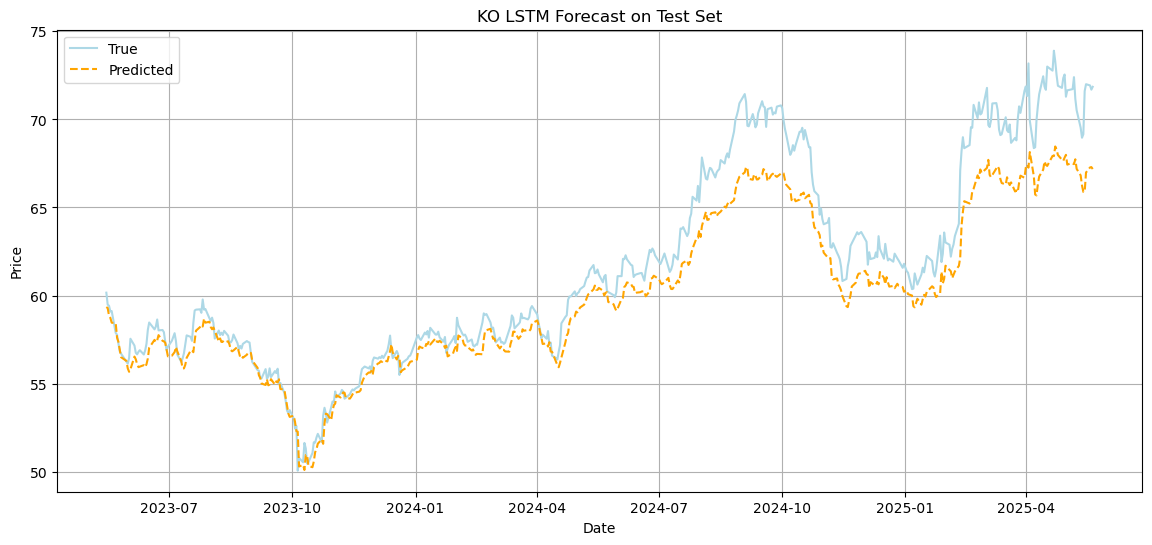

In [780]:
plt.figure(figsize=(14, 6))
plt.plot(dates_test.flatten(), np.array(y_test_flat), label='True', color='lightblue')
plt.plot(dates_test.flatten(), np.array(y_pred_flat), label='Predicted', linestyle='--', color='orange')
plt.title(f'{ticker} LSTM Forecast on Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


## Future Prediction

In [781]:
future_predictions = []
prediction_length = n_days
input_seq = data_scaled[-sequence_length:].reshape((1, sequence_length, data_scaled.shape[1]))

In [782]:
pred = model.predict(input_seq)  # shape: (1, n_steps_out, 1)
pred_close_scaled = pred[0, :, 0]  # shape: (n_steps_out,)
future_predictions = pred_close_scaled.tolist()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [783]:
temp = np.zeros((n_days, data_scaled.shape[1]))
temp[:, close_idx] = future_predictions
future_pred_prices = scaler.inverse_transform(temp)[:, close_idx]

In [785]:
print(f"Future predictions for the next {n_days} days: {future_pred_prices}")

Future predictions for the next 1 days: [66.95150755]


In [787]:
data_predict = yf.download(ticker, start='2025-05-02', end='2025-05-03')

# Actual Close prices for the next day
print(data_predict['Close'])

[*********************100%***********************]  1 of 1 completed

Ticker             KO
Date                 
2025-05-02  71.650002
